### Introduction to Machine Learning Graph

Install and run Neo4j Community Edition with GDS 2.6

In [ ]:
#!/usr/bin/env python3
import subprocess
import os
import urllib.request
import time

def setup_neo4j_with_gds():
    container_name = "neo4j"
    password = "password"

    # Create local files
    os.makedirs("./neo4j_data/plugins", exist_ok=True)
    os.makedirs("./neo4j_data/data", exist_ok=True)
    os.makedirs("./neo4j_data/logs", exist_ok=True)

    # Downloading the GDS 2.6 plugin
    gds_jar = "./neo4j_data/plugins/neo4j-graph-data-science-2.6.0.jar"
    if not os.path.exists(gds_jar):
        print("Downloading GDS 2.6...")
        url = "https://github.com/neo4j/graph-data-science/releases/download/2.6.0/neo4j-graph-data-science-2.6.0.jar"
        urllib.request.urlretrieve(url, gds_jar)
        print(f"GDS downloaded ({os.path.getsize(gds_jar)/(1024*1024):.1f} MB)")

    # Stop and delete the old container if it exists
    subprocess.run(['docker', 'stop', container_name], stderr=subprocess.DEVNULL)
    subprocess.run(['docker', 'rm', container_name], stderr=subprocess.DEVNULL)

    # Absolute paths for Docker
    paths = {p: os.path.abspath(f"./neo4j_data/{p}") for p in ["plugins","data","logs"]}

    # Launch of Neo4j Community with Docker
    cmd = [
        "docker", "run", "--name", container_name,
        "-p", "7474:7474", "-p", "7687:7687",
        "-e", f"NEO4J_AUTH=neo4j/{password}",
        "-e", "NEO4J_dbms_security_procedures_unrestricted=gds.*",
        "-e", "NEO4J_dbms_security_procedures_allowlist=gds.*",
        "-v", f"{paths['plugins']}:/plugins",
        "-v", f"{paths['data']}:/data",
        "-v", f"{paths['logs']}:/logs",
        "-d", "neo4j:5.15.0-community"
    ]
    subprocess.run(cmd, check=True)

    print("Neo4j Community launched with GDS 2.6! Awaiting full startup...")
    time.sleep(20)  # wait 20 seconds for Neo4j to be ready
    print("Neo4j should be ready to connect to bolt://localhost:7687")

# Run the setup
setup_neo4j_with_gds()

Neo4j Community launched with GDS 2.6! Awaiting full startup...
Neo4j should be ready to connect to bolt://localhost:7687


In [4]:
# Displays running Docker containers
!docker ps

CONTAINER ID   IMAGE                    COMMAND                  CREATED              STATUS              PORTS                                                                                      NAMES
6691a939dbe5   neo4j:5.15.0-community   "tini -g -- /startup…"   About a minute ago   Up About a minute   0.0.0.0:7474->7474/tcp, [::]:7474->7474/tcp, 0.0.0.0:7687->7687/tcp, [::]:7687->7687/tcp   neo4j


In [5]:
# Displays logs of the Neo4j container
!docker logs neo4j

Changed password for user 'neo4j'. IMPORTANT: this change will only take effect if performed before the database is started for the first time.
2025-11-29 13:24:55.019+0000 INFO  Logging config in use: File '/var/lib/neo4j/conf/user-logs.xml'
2025-11-29 13:24:55.039+0000 INFO  Starting...
2025-11-29 13:24:55.976+0000 INFO  This instance is ServerId{2db00488} (2db00488-9432-4d7a-8fae-6c472a7260a3)
2025-11-29 13:24:56.664+0000 INFO  ======== Neo4j 5.15.0 ========
2025-11-29 13:24:56.814+0000 INFO  Progress tracking: enabled
2025-11-29 13:24:56.817+0000 INFO  Memory usage guard: minimum estimate
2025-11-29 13:24:56.839+0000 INFO  GDS license file: null
2025-11-29 13:24:56.842+0000 INFO  GDS license state: unlicensed
2025-11-29 13:24:56.873+0000 INFO  Register GraphDataScience...
2025-11-29 13:24:56.974+0000 INFO  GraphDataScience registered.
2025-11-29 13:24:56.976+0000 INFO  Register GraphDataScienceExtras...
2025-11-29 13:24:56.979+0000 INFO  GraphDataScienceExtras registered.
2025-11-2

In [6]:
# Lists all Docker images
!docker images

REPOSITORY   TAG                IMAGE ID       CREATED         SIZE
neo4j        5.15.0-community   d9e2fb1ba398   22 months ago   799MB


Connect to the Neo4j instance running in Docker through the Python client to interact with the database

In [8]:
from neo4j import GraphDatabase

URI = "bolt://localhost:7687"
AUTH = ("neo4j", "password")

# Connect to Neo4j
try:
    driver = GraphDatabase.driver(URI, auth=AUTH)
    driver.verify_connectivity()  # raises if cannot connect
except Exception as e:
    print("Neo4j connection failed:", e)
    raise

# print the driver object 
driver

In [9]:
import subprocess

cmd = 'docker exec neo4j cypher-shell -u neo4j -p password "RETURN gds.version();"'
result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
print(result.stdout or result.stderr)

gds.version()
"2.6.0"



Define a concise encapsulation function to run Cypher queries directly on our Neo4j Docker instance

In [10]:
def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        return result.to_df()

Display all databases that are loaded and available on your Neo4j instance inside Docker

In [11]:
run_query("""
SHOW DATABASES
""")

,name,type,aliases,access,address,role,writer,requestedStatus,currentStatus,statusMessage,default,home,constituents
0,neo4j,standard,[],read-write,localhost:7687,primary,True,online,online,,True,True,[]
1,system,system,[],read-write,localhost:7687,primary,True,online,online,,False,False,[]


Create a constraint with the name `Stream`

In [12]:
run_query("""
CREATE CONSTRAINT StreamUniqueId IF NOT EXISTS
FOR (s:Stream)
REQUIRE s.id IS UNIQUE
""")

""


Import the Twitch streamer CSV available at https://bit.ly/3JjgKgZ and set the necessary properties

In [13]:
run_query("""
LOAD CSV WITH HEADERS FROM 'https://bit.ly/3JjgKgZ' AS row
WITH row
WHERE row.id IS NOT NULL AND row.id <> ''
MERGE (s:Stream {id: row.id})
ON CREATE SET
    s.language = row.language;
""")

""


Import the Twitch streamer audience relationship CSV from https://bit.ly/3S9Uyd8 and leverage Neo4j’s using `IN TRANSACTIONS` feature to process the data in batches rather than loading it entirely at once

In [14]:
run_query("""
LOAD CSV WITH HEADERS FROM 'https://bit.ly/3S9Uyd8' AS row
WITH row
WHERE row.source IS NOT NULL AND row.source <> ''
  AND row.target IS NOT NULL AND row.target <> ''
CALL {
    WITH row
    MERGE (s1:Stream {id: row.source})
    MERGE (s2:Stream {id: row.target})
    MERGE (s1)-[:CO_VIEWED {
        weight: CASE WHEN row.weight <> '' THEN toInteger(row.weight) ELSE 0 END
    }]->(s2)
} IN TRANSACTIONS OF 500 ROWS
""")

""


In [15]:
# Update the relationship property 'viewer' with the value of 'weight', defaulting to 0 if 'weight' is null
run_query("""
MATCH ()-[r:CO_VIEWED]->()
SET r.viewer = coalesce(r.weight, 0)
""")

run_query("""
MATCH ()-[r:CO_VIEWED]->()
REMOVE r.weight
""")

""


Create a graph projection using the Neo4j GDS *(Graph Data Science)* plugin

In [16]:
run_query("""
CALL gds.graph.project(
    'coViewedGraph',
    'Stream',
    {
        CO_VIEWED: {
            orientation: 'UNDIRECTED',
            properties: ['viewer']
        }
    }
)
""")

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Stream': {'label': 'Stream', 'properties': {}}}","{'CO_VIEWED': {'aggregation': 'DEFAULT', 'orie...",coViewedGraph,3721,262854,1993


The `coViewedGraph` is projected as an **undirected graph** because of the nature of the relationship being modeled: co-viewing between two streams.

The core reason is **symmetry**. The `CO_VIEWED` relationship inherently means that if Stream A was viewed by the same person *(`viewer`)* who viewed Stream B, then the reverse is also true: Stream B was viewed by the same person who viewed Stream A.

If (Stream A) $\xrightarrow{\text{CO\_VIEWED}}$ (Stream B), then (Stream B) $\xrightarrow{\text{CO\_VIEWED}}$ (Stream A).

Since the interaction has no inherent direction *(neither stream causes the other to be viewed first, or is prioritized)*, the relationship is symmetric. Representing it with two distinct directed edges would be redundant and unnecessary complexity.

Apply the Node2Vec algorithm from the GDS plugin to generate embeddings for your graph data

In [17]:
run_query("""
CALL gds.node2vec.write(
  'coViewedGraph',
  {
    embeddingDimension: 8,
    relationshipWeightProperty: 'viewer',
    inOutFactor: 0.5,
    returnFactor: 1.0,
    walkLength: 40,
    walksPerNode: 10,
    concurrency: 4,
    writeProperty: 'node2vec'
  }
)
""")

,nodeCount,nodePropertiesWritten,preProcessingMillis,computeMillis,writeMillis,configuration,lossPerIteration
0,3721,3721,0,3297,212,"{'writeProperty': 'node2vec', 'walkLength': 40...",[10601667.198562877]


Plot the distribution of embedding distances between pairs of nodes that share a relationship *(comparison between the Euclidean and cosine distance metrics)*

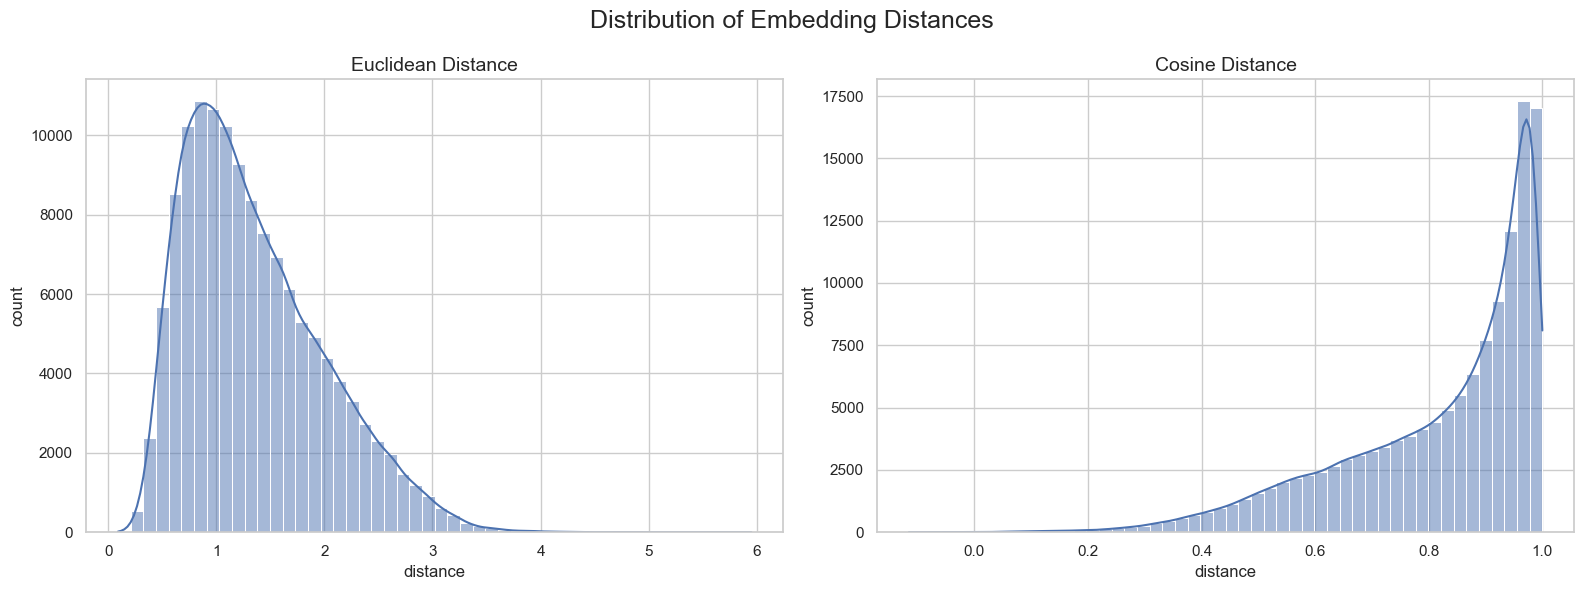

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (16, 6)
sns.set(style="whitegrid")

df = run_query("""
            MATCH (c1:Stream)-[:CO_VIEWED]->(c2:Stream)
            WITH c1.node2vec AS v1, c2.node2vec AS v2
            UNWIND [
            {metric: 'euclidean', value: gds.similarity.euclideanDistance(v1, v2)},
            {metric: 'cosine',    value: gds.similarity.cosine(v1, v2)}
            ] AS m
            RETURN m.value AS distance, m.metric AS metric;
               """)

# --- Subplots ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

metrics = ["euclidean", "cosine"]

for ax, metric in zip(axes, metrics):
    sns.histplot(
        data=df[df["metric"] == metric],
        x="distance",
        bins=50,
        kde=True,
        ax=ax)
    ax.set_title(f"{metric.capitalize()} Distance", fontsize=14)
    ax.set_xlabel("distance")
    ax.set_ylabel("count")

plt.suptitle("Distribution of Embedding Distances", fontsize=18)
plt.tight_layout()
plt.show()

Discuss any observations that can be draw from their differences

The two plots display the distributions for the same set of embedding distances, highlighting the fundamental differences in how Euclidean distance and Cosine distance characterize the **similarity** between high-dimensional vectors.

1. **Euclidean Distance Distribution**

- **Shape:** The distribution is highly **right-skewed**, resembling a **log-normal** distribution. It starts near 0, peaks around $d=0.9$ and then has a long tail, extending up to $d=6.0$.

- **Interpretation:** The Euclidean distance measures the **absolute magnitude** of the difference between two vectors *(i.e., the straight-line distance in the embedding space)*:

    - The vast majority of node pairs are clustered **relatively close** together, with distances less than $2.0$. This suggests that the embeddings that share a relationship are mapped to a relatively small, dense region of the embedding space.

    - The long tail indicates that there are still some pairs with **large absolute differences** in their embeddings, even though they share a relationship. This might happen if the relationship is broad or if the embedding space is large.

2. **Cosine Distance Distribution**

- **Shape:** The distribution is heavily left-skewed. It starts near $d=0.2$, gradually increases and shows a very sharp peak at the high end, specifically around $d=0.9$.

- **Interpretation:** The Cosine distance (which is $1 - \text{Cosine Similarity}$) measures the **angular separation** between two vectors, regardless of their magnitude or length.

    - Since the distribution peaks strongly at $d=0.9$, this means the **Cosine SImilarity** is very low (close to 0.1 to 0.2) for most pairs. A low cosine similarity implies the vectors are **close to orthogonal** in the high dimensional space.

    - Conversely, the presence of counts near $d = 0.2$ is very low, meaning very few vectors are highly parallel *(similar)*.

3. **Key Difference and Implications**

The stark difference between the two distributions highlights why the choice of distance metric matters for high-dimensional data, a phenomenon often related to the **Curse of Dimensionality:**

- **Euclidean Distance** is sensitive to the **magnitude** of the vectors. The distribution shows that embeddings with a shared relationship are generally **close in absolute position**.

- **Cosine Distance** is sensitive only to the **direction** of the vectors. The distribution shows that, even though the vectors are close in absolute position (Euclidean distance is small), their **relative orientations** are often near $90^\circ$ (orthogonal).

In high-dimensional spaces, many vectors tend to become nearly orthogonal to each other, even when they are close in terms of absolute Euclidean distance. This pattern often makes **Euclidean distance less effective** in distinguishing similarity in high dimensions, as the relative difference in angle *(Cosine distance)* may better capture the concept of "similarity" for many machine learning tasks. The sharp difference suggests that for these embeddings, **magnitude varies significantly less than direction**.

Compute the degree distribution using cosine similarity and plot the results using `seaborn.barplot()`

<Axes: xlabel='cosineSimilarity', ylabel='avgDegree'>

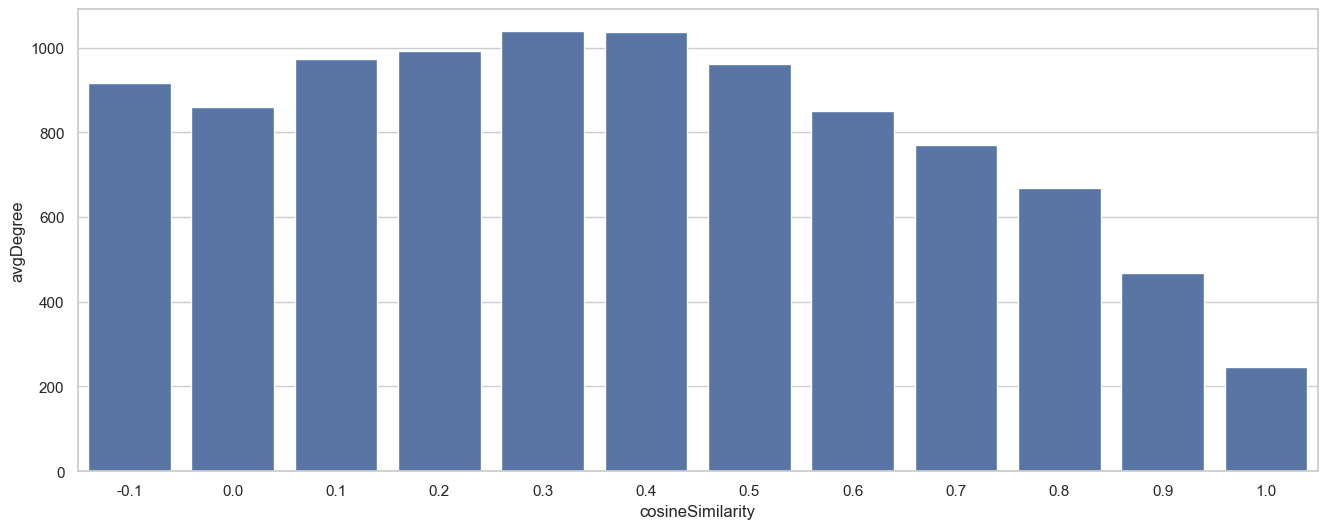

In [19]:
df = run_query("""
MATCH (c1:Stream)-[:CO_VIEWED]->(c2:Stream)
WITH
  round(gds.similarity.cosine(c1.node2vec, c2.node2vec), 1) AS cosineSimilarity,
  count { (c1)--() } + count { (c2)--() } AS degreeSum
RETURN
  cosineSimilarity,
  avg(degreeSum) AS avgDegree
ORDER BY cosineSimilarity;
""")

sns.barplot(data=df,
            x="cosineSimilarity",
            y="avgDegree")

Plot the cosine similarity against the average weighted degree in the network

<Axes: xlabel='cosineSimilarity', ylabel='avgViewer'>

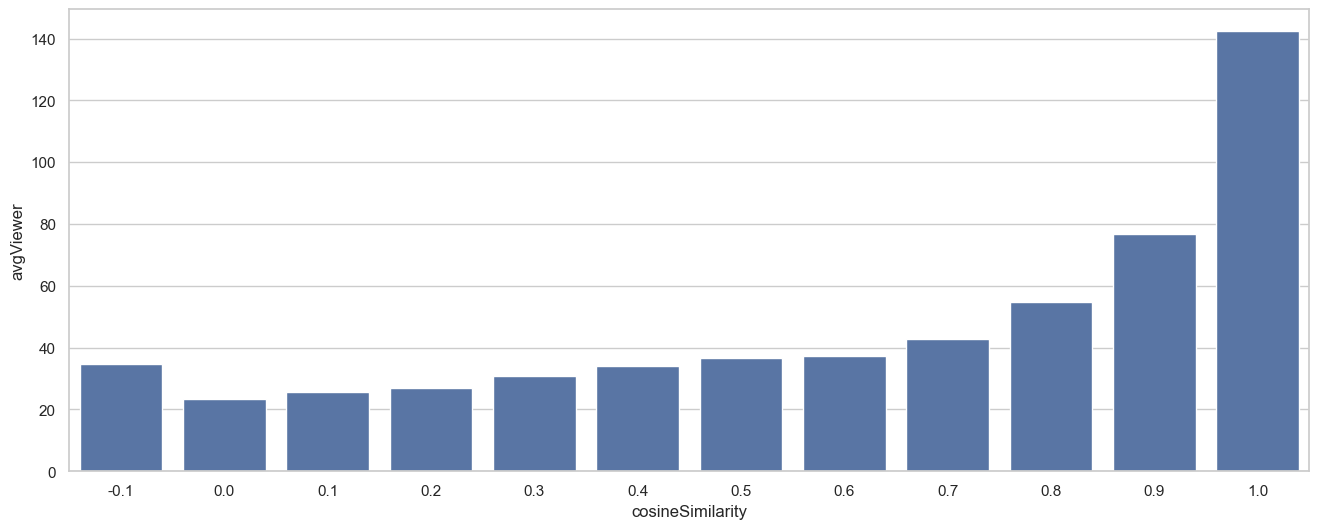

In [31]:
df = run_query("""
MATCH (c1:Stream)-[r:CO_VIEWED]->(c2:Stream)
WITH
  round(gds.similarity.cosine(c1.node2vec, c2.node2vec), 1) AS cosineSimilarity,
  r.viewer AS viewer
RETURN
  cosineSimilarity,
  avg(viewer) AS avgViewer
ORDER BY cosineSimilarity ASC;
""")

sns.barplot(data=df, 
            x="cosineSimilarity", 
            y="avgViewer")

Export the data to a Pandas DataFrame to prepare it for a Random Forest classifier

In [21]:
import pandas as pd
import numpy as np

df = run_query("""
MATCH (s:Stream)
RETURN s.id AS streamId,
       s.language AS language,
       s.node2vec AS embedding
""")

df.columns = ["streamId", "language", "embedding"]
df["embedding"] = df["embedding"].apply(lambda v: np.array(v, dtype=float))
df["language"] = df["language"].fillna("unknown")
codes, uniques = pd.factorize(df["language"], sort=True)
df["label"] = codes

language_mapping = dict(enumerate(uniques))
df.head()

,streamId,language,embedding,label
0,129004176,en,"[1.658036231994629, 0.4318455457687378, 0.1828...",1
1,26490481,en,"[1.660603642463684, -0.14824074506759644, -0.5...",1
2,213749122,en,"[1.7708426713943481, -0.15208473801612854, 0.4...",1
3,30104304,en,"[1.227268934249878, -0.08737891912460327, 0.00...",1
4,160504245,en,"[1.602252721786499, -0.05609918758273125, 0.02...",1


Initialize a `RandomForestClassifier`, split the dataset, train the model and display `classification_report`

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# --- Prepare X and y properly (convert list of vectors into matrix) ---
X = np.vstack(df["embedding"].values)   # shape: (n_samples, embedding_dim)
y = df["label"].values                  # shape: (n_samples,)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Random Forest with better defaults ---
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42,
)

# --- Train ---
model.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
# --- Eval ---
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86        56
           1       0.92      0.89      0.91       364
           2       0.85      0.95      0.90        61
           3       0.96      1.00      0.98        50
           4       0.93      0.96      0.94        26
           5       0.96      0.94      0.95        52
           6       0.89      0.89      0.89        38
           7       0.85      0.88      0.87        51
           8       0.85      0.88      0.87        26
           9       0.91      1.00      0.95        21

    accuracy                           0.91       745
   macro avg       0.90      0.92      0.91       745
weighted avg       0.91      0.91      0.91       745



Visualize the confusion matrix as a heatmap

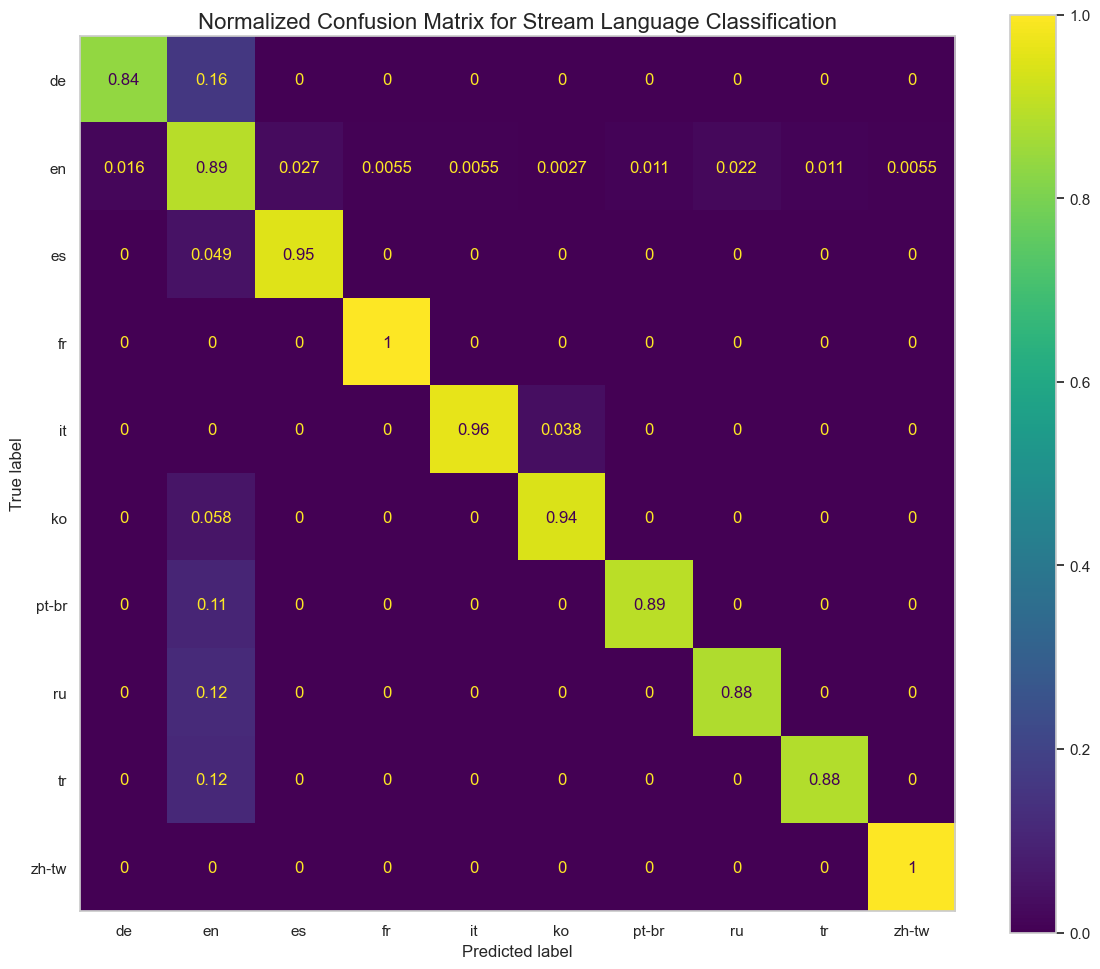

In [24]:
# --- Get class names from language mapping ---
class_names = [language_mapping[i] for i in sorted(language_mapping.keys())]

# --- Plot confusion matrix ---
fig, ax = plt.subplots(figsize=(12, 10))

disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=class_names,
    normalize="true",   # shows proportion instead of raw counts
    ax=ax
)

# --- Remove grid ---
ax.grid(False)

ax.set_title("Normalized Confusion Matrix for Stream Language Classification", fontsize=16)
plt.tight_layout()
plt.show()

#### Questions

1. What do you think about this matrix?

Since the matrix is normalized *(the rows sum up to 1)*, the values represent the **Recall** *(or True Positive Rate)* for each language class.

- **Diagonal Values:** These are the **correct classifications** *(True Positive)* for each language. For example, for German *(de)*, the recall is 0.84, meaning 84% of all German streams were correctly identified as German.

- **Off-Diagonal Values:** These are **misclassifications** *(False Negatives)* where the true language was labeled incorrectly. For example, for Italian (it), the misclassification is with korean (ko) at 0.038 (3.8%).

- Performance Summary:
    - The model performs very well for most languages, with recalls generally above 0.88 *(except for de)*.
    - The **best performance** is for zh-tw *(Traditional Chinese, Taiwan)* and fr *(French)*, both at 1.00 (100% recall).
    - The **weakest performance** is for de *(German)* at 0.84 and en *(English)* at 0.89.
    - English (en) is the most common language to be **confused with other languages** *(high False Negatives)*, particularly de (1.6%), es (2.7%), and ru (2.2%).

2. What is the appropriate metrics to select among the classification report to show your manager and why ?

The most appropriate metric to select from the classification report is the **F1-Score**, specifically the **Weighted-Average F1-Score**.

The Weighted-Average F1-Score is the best single number summary for overall performance:
- **What it is:** The F1-Score is the **harmonic mean** of **Precision** and **Recall**, providing a balanced single metric. The Weighted-Average aggregates the individual F1-Scores for each of the 10 languages, weighting them by the number of samples *(streams)* that actually belong to that class *(the class support)*.

- **Why it's appropriate:**
    - **Balance:** F1-Score is better than simple Accuracy in imbalanced datasets *(which stream data often is)*. It penalizes models if either Precision or Recall is low.

    - **Real-World Representation:** By using the **weighted average**, the metric gives more importance to the most common languages in your system *(e.g., English, which has the most data)*, providing a more realistic and actionable score for the overall performance of the service.

    - **Managerial View:** This single score *(0.91 for our model)* is easy to understand and track over time as a primary Key Performance Indicator (KPI).

3. How can you improve the classifiers quality ?

To improve the quality of your language classifier, specifically addressing the weaknesses identified *(low 'de' Recall and high 'en' confusion)*, focus on the following three strategies:

- **Targeted Data Collection (Focus on Problematic Classes)**
    - **Low 'de' (German) Recall:** Prioritize acquiring and accurately labeling new German stream data. This directly tackles the False Negatives observed (Recall 0.84) and is essential for comprehensive language identification.

    - **High 'en' (English) Confusion:** Analyze the misclassified English examples *(e.g., 'en' labeled as 'es' or 'ru')*. Re-introduce these challenging, borderline samples (*e.g., short chats, code-switching)* with correct labels to help the model learn finer distinctions and reduce off-diagonal errors.

- **Handling Class Imbalance**

    Assuming your classes have unequal sample sizes *(e.g., English is dominant)*, imbalance can bias the model.

    - **Weighted Loss Function:** Modify the model's training objective to assign higher penalty weights to errors made on the minority/difficult class (German). This forces the model to prioritize learning the 'de' class better.

    - **Resampling Techniques:**
        - **Oversampling:** Increase the representation of the minority class *(German)* by duplicating or generating synthetic samples. This is highly effective for boosting Recall.

        - **Undersampling:** Reduce the number of samples from the majority class *(English)*, but use caution to avoid losing valuable information.

- **Hyperparameter Tuning**

    Systematically optimize the model's internal settings to achieve peak performance on your data.

    - **Systematic Search:** Use methods like Grid Search or Bayesian Optimization to efficiently explore parameter space instead of manual trial and error.

    - **Optimization Metric:** Ensure the tuning process is optimized to maximize the Weighted-Average F1-Score, as this is the balanced metric critical for overall performance reporting.